# **Imports**

In [1]:
!pip install memory_profiler

In [2]:
import random
import math
from collections import deque
import heapq
import time
import numpy as np
from memory_profiler import memory_usage
import networkx as nx
from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt

# **Environment**

In [3]:
class Environment:
    def __init__(self, size, obstacle_density, num_goals):
        self.grid = self.generate_grid(size, obstacle_density)
        self.goals = sorted(self.generate_goals(num_goals))

    def generate_grid(self, size, obstacle_density):
        grid = []
        for i in range(size):
            row = []
            for j in range(size):
                row.append(1 if random.random() < obstacle_density else 0)
            grid.append(row)
        return grid

    def generate_goals(self, num_goals):
        goals = []
        size = len(self.grid)
        while len(goals) < num_goals:
            x, y = random.randint(0, size - 1), random.randint(0, size - 1)
            if self.grid[x][y] == 0 and (x, y) not in goals:
                goals.append((x, y))
        return goals

    def is_valid_position(self, position):
        x, y = position
        if 0 <= x < len(self.grid) and 0 <= y < len(self.grid[0]):
            return self.grid[x][y] == 0
        return False

    def get_goals(self):
        return self.goals

# **Single-Agent**

In [4]:
class Robot:
    def __init__(self, position, environment, goals):
        self.position = position
        self.env = environment
        self.delivered = {goal: False for goal in goals}
        self.goals = goals

    def is_goal_reached(self):
        return all(self.delivered.values())

    def update_delivery(self, position):
        if position in self.delivered:
            self.delivered[position] = True

    def get_valid_neighbors(self):
        directions = ["N", "S", "E", "W"]
        neighbors = []
        for direction in directions:
            dx, dy = {"N": -1, "S": 1, "E": 0, "W": 0}[direction], {"N": 0, "S": 0, "E": 1, "W": -1}[direction]
            next_position = (self.position[0] + dx, self.position[1] + dy)
            if self.env.is_valid_position(next_position):
                neighbors.append(next_position)
        return neighbors


# **Comaprison and Visualizing**

In [5]:
class SearchComparison:
    def __init__(self, robot, algorithms):
        self.robot = robot
        self.algorithms = algorithms
        self.results = {}

    def measure_performance(self):
        for name, algorithm in self.algorithms.items():
            self.robot.position = (0, 0)
            self.robot.delivered = {goal: False for goal in self.robot.goals}

            start_time = time.time()
            mem_usage = memory_usage((algorithm, (self.robot,)), max_usage=True)
            path = algorithm(self.robot)
            end_time = time.time()

            self.results[name] = {
                'time': end_time - start_time,
                'memory': mem_usage,
                'path_length': len(path) if path else float('inf'),
                'path': path,
                'success': path is not None
            }

    def visualize_grid(self, path=None, visited=None, title="Grid Visualization"):
        grid = np.array(self.robot.env.grid)
        plt.figure(figsize=(8, 8))

        plt.imshow(grid, cmap='binary', origin='upper')

        if visited:
            visited_y, visited_x = zip(*visited)
            plt.scatter(visited_x, visited_y, color='lightblue', alpha=0.3, label='Visited')

        if path:
            if all(isinstance(i, str) for i in path):
                coordinates = self.convert_directions_to_coordinates(path)
            else:
                coordinates = path

            path_y, path_x = zip(*coordinates)
            plt.plot(path_x, path_y, 'g-', linewidth=2, label='Path')

        plt.plot(self.robot.position[1], self.robot.position[0], 'go', markersize=15, label='Start')
        goal_y, goal_x = zip(*self.robot.goals)
        plt.plot(goal_x, goal_y, 'ro', markersize=15, label='Goals')

        plt.grid(True)
        plt.title(title)
        plt.legend()
        plt.show()

    def convert_directions_to_coordinates(self, directions):
        position = self.robot.position
        coordinates = [position]
        valid_path = True

        for direction in directions:
            dx, dy = {"N": -1, "S": 1, "E": 0, "W": 0}[direction], {"N": 0, "S": 0, "E": 1, "W": -1}[direction]
            next_position = (position[0] + dx, position[1] + dy)

            if self.robot.env.is_valid_position(next_position):
                coordinates.append(next_position)
                position = next_position
            else:
                valid_path = False
                break

        return coordinates if valid_path else coordinates[:1]  # Return only start position if path is invalid

    def plot_comparison(self):
        metrics = ['time', 'memory', 'path_length']
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for idx, metric in enumerate(metrics):
            values = [self.results[alg][metric] for alg in self.algorithms]
            axes[idx].bar(self.algorithms.keys(), values)
            axes[idx].set_title(f'{metric.capitalize()} Comparison')
            axes[idx].set_xticklabels(self.algorithms.keys(), rotation=45)

        plt.tight_layout()
        plt.show()

    def print_comparison_table(self):
        print("\nAlgorithm Comparison Results:")
        print("-" * 80)
        print(f"{'Algorithm':<15} {'Time (s)':<12} {'Memory (MB)':<12} {'Path Length':<12} {'Success':<8}")
        print("-" * 80)

        for name in self.algorithms:
            result = self.results[name]
            print(f"{name:<15} {result['time']:<12.3f} {result['memory']:<12.1f} "
                  f"{result['path_length']:<12} {result['success']:<8}")
        print("-" * 80)


# **Q-Learning**

In [6]:
class QLearning:
    def __init__(self, robot, learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0, min_exploration_rate=0.01, exploration_decay=0.995):
        self.robot = robot
        self.alpha = learning_rate  # Learning rate
        self.gamma = discount_factor  # Discount factor
        self.epsilon = exploration_rate  # Exploration rate
        self.min_epsilon = min_exploration_rate
        self.epsilon_decay = exploration_decay  # Add this line
        self.q_table = {}  # Q-table for state-action pairs
        self.training_rewards = []  # Track rewards per episode
        self.q_value_history = []  # Track Q-value evolution
        self.policy_history = []   # Track policy changes
        self.epsilon_history = []  # Add this line to track epsilon values
        self.max_steps = 200  # Increased max steps
        self.step_penalty = -0.05  # Reduced step penalty
        self.obstacle_penalty = -5.0  # Increased obstacle penalty
        self.goal_reward = 100.0  # Reduced goal reward to more reasonable value
        self.closer_bonus = 2.0  # Increased bonus for getting closer
        self.farther_penalty = -1.0  # New penalty for getting farther
        self.consecutive_goal_bonus = 50.0  # New bonus for reaching multiple goals
        self.visited_penalty = -0.1  # New penalty for revisiting states
        self.initial_q_value_range = (-0.1, 0.1)  # Range for initial Q-values
        self.direction_preferences = {
            'N': 0.1,  # Slight preference for different directions
            'S': -0.1,
            'E': 0.2,
            'W': -0.2
        }
        self.episode_rewards = []  # Add this line to store rewards per episode

    def initialize_q_table(self):
        all_subsets = list(product([False, True], repeat=len(self.robot.goals)))
        for x in range(len(self.robot.env.grid)):
            for y in range(len(self.robot.env.grid[0])):
                for subset in all_subsets:
                    state_delivered = tuple((g, st) for g, st in zip(self.robot.goals, subset))
                    state = ((x, y), state_delivered)

                    # Initialize with directional preferences
                    self.q_table[state] = {
                        action: random.uniform(*self.initial_q_value_range) + self.direction_preferences[action]
                        for action in ["N", "S", "E", "W"]
                    }

                    # Special initialization for goal states
                    if (x, y) in self.robot.goals:
                        undelivered_goals = [g for g, d in state_delivered if not d]
                        if (x, y) in undelivered_goals:
                            # Initialize goal state with different values based on next goals
                            next_goals = [g for g in undelivered_goals if g != (x, y)]
                            if next_goals:
                                next_goal = min(next_goals, key=lambda g: manhattan_distance((x, y), g))
                                dx, dy = next_goal[0] - x, next_goal[1] - y

                                # Set higher values for actions leading to next goals
                                for action in ["N", "S", "E", "W"]:
                                    if (action == "N" and dx < 0) or (action == "S" and dx > 0) or \
                                       (action == "E" and dy > 0) or (action == "W" and dy < 0):
                                        self.q_table[state][action] = self.goal_reward
                                    else:
                                        self.q_table[state][action] = self.goal_reward * 0.8
                            else:
                                # Last goal reached - all actions equally good
                                for action in ["N", "S", "E", "W"]:
                                    self.q_table[state][action] = self.goal_reward

    def choose_action(self, state):
        # Epsilon-greedy strategy for action selection
        if random.random() < self.epsilon:
            return random.choice(["N", "S", "E", "W"])
        else:
            return max(self.q_table[state], key=self.q_table[state].get)

    def update_q_value(self, state, action, reward, next_state, effective_lr=None):
        if effective_lr is None:
            effective_lr = self.alpha

        # Get the best next action value, considering unvisited states more valuable
        next_values = self.q_table[next_state].copy()
        for a in next_values:
            next_pos = get_next_position(next_state[0], a)
            if next_pos in [s[0] for s in self.visited_states[-10:]]:  # Check last 10 visited states
                next_values[a] += self.visited_penalty

        best_next_value = max(next_values.values())

        # Update Q-value with momentum
        current_q = self.q_table[state][action]
        momentum = 0.9 if reward > 0 else 0.1  # Higher momentum for positive rewards

        new_q = current_q + effective_lr * (
            reward + self.gamma * best_next_value - current_q
        ) + momentum * self.direction_preferences[action]

        self.q_table[state][action] = new_q

    def train(self, episodes=1000):
        self.initialize_q_table()
        self.q_value_history = []  # Reset history at start of training
        self.visited_states = []  # Track visited states

        for episode in range(episodes):
            # Take snapshot at the start of every 50th episode
            if episode % 50 == 0:
                initial_state = ((0, 0), tuple((g, False) for g in self.robot.goals))
                q_snapshot = {
                    'episode': episode,
                    'start_state': self.q_table[initial_state].copy(),
                    'avg_q': np.mean([max(actions.values()) for actions in self.q_table.values()])
                }
                self.q_value_history.append(q_snapshot)

            self.robot.position = (0, 0)
            self.robot.delivered = {goal: False for goal in self.robot.goals}
            episode_states = []
            state = (self.robot.position, tuple(self.robot.delivered.items()))
            total_reward = 0
            steps = 0

            while not all(self.robot.delivered.values()) and steps < self.max_steps:
                explore_prob = self.epsilon * (1 - (steps / self.max_steps))
                if random.random() < explore_prob:
                    action = random.choice(["N", "S", "E", "W"])
                else:
                    action = max(self.q_table[state], key=self.q_table[state].get)

                next_position, reward, next_state, done = self.take_action(state, action)
                episode_states.append(state[0])

                visit_count = episode_states.count(state[0])
                effective_lr = self.alpha / (1 + 0.1 * visit_count)

                self.update_q_value(state, action, reward, next_state, effective_lr)
                state = next_state
                total_reward += reward
                steps += 1

                if done:
                    break

            # Update training progress
            self.visited_states.extend(episode_states)
            self.episode_rewards.append(total_reward)

            # Decay exploration rate
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def take_action(self, state, action):
        current_pos = self.robot.position
        dx, dy = {"N": -1, "S": 1, "E": 0, "W": 0}[action], {"N": 0, "S": 0, "E": 1, "W": -1}[action]
        next_position = (current_pos[0] + dx, current_pos[1] + dy)

        # Check if hit obstacle or wall
        if not self.robot.env.is_valid_position(next_position):
            return next_position, self.obstacle_penalty, state, False

        # Calculate distance metrics
        undelivered_goals = [g for g in self.robot.goals if not self.robot.delivered[g]]
        if not undelivered_goals:
            return next_position, self.goal_reward, next_state, True

        old_distances = [manhattan_distance(current_pos, g) for g in undelivered_goals]
        new_distances = [manhattan_distance(next_position, g) for g in undelivered_goals]

        min_old_dist = min(old_distances)
        min_new_dist = min(new_distances)

        # Calculate distance-based reward
        if min_new_dist < min_old_dist:
            distance_reward = self.closer_bonus
        elif min_new_dist > min_old_dist:
            distance_reward = self.farther_penalty
        else:
            distance_reward = 0

        # Move robot
        self.robot.position = next_position
        reward = self.step_penalty + distance_reward

        # Check if reached a goal
        delivered_count = sum(self.robot.delivered.values())
        if self.robot.position in self.robot.goals and not self.robot.delivered[self.robot.position]:
            reward += self.goal_reward + (delivered_count * self.consecutive_goal_bonus)
            self.robot.delivered[self.robot.position] = True

        next_state = (self.robot.position, tuple(self.robot.delivered.items()))
        done = all(self.robot.delivered.values())

        return next_position, reward, next_state, done

    def analyze_performance(self):
        # Print Q-table statistics
        print("\nQ-Table Analysis:")
        print("-" * 80)

        # Add reward statistics
        print("Reward Statistics:")
        print(f"Average reward per episode: {np.mean(self.episode_rewards):.2f}")
        print(f"Max reward achieved: {np.max(self.episode_rewards):.2f}")
        print(f"Min reward: {np.min(self.episode_rewards):.2f}")
        print(f"Standard deviation: {np.std(self.episode_rewards):.2f}")
        print(f"Last 10 episodes average reward: {np.mean(self.episode_rewards[-10:]):.2f}")

        # Visualize rewards
        plt.figure(figsize=(10, 5))
        plt.plot(self.episode_rewards)
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)

        # Add moving average
        window_size = 20
        moving_avg = np.convolve(self.episode_rewards,
                                np.ones(window_size)/window_size,
                                mode='valid')
        plt.plot(range(window_size-1, len(self.episode_rewards)),
                moving_avg,
                'r',
                label=f'Moving average ({window_size} episodes)')
        plt.legend()
        plt.show()

        # Rest of the analysis code
        print("\nState-Action Value Statistics:")
        # ...existing code...

        # Calculate statistics for Q-values
        all_q_values = []
        for state in self.q_table:
            all_q_values.extend(self.q_table[state].values())

        print(f"Average Q-value: {np.mean(all_q_values):.2f}")
        print(f"Max Q-value: {np.max(all_q_values):.2f}")
        print(f"Min Q-value: {np.min(all_q_values):.2f}")
        print(f"Standard deviation: {np.std(all_q_values):.2f}")

        # Print sample of Q-values for interesting states
        print("\nSample Q-values for key states:")
        self.print_interesting_states()

        # Print Q-value evolution
        print("\nQ-value Evolution:")
        self.print_q_value_evolution()

    def print_interesting_states(self):
        # Print Q-values for start state and goal states
        start_state = ((0, 0), tuple(self.robot.delivered.items()))
        print(f"\nStart state Q-values:")
        self.print_state_q_values(start_state)

        for goal in self.robot.goals:
            state = (goal, tuple(self.robot.delivered.items()))
            if state in self.q_table:
                print(f"\nGoal state {goal} Q-values:")
                self.print_state_q_values(state)

    def print_state_q_values(self, state):
        if state in self.q_table:
            for action, value in self.q_table[state].items():
                print(f"Action {action}: {value:.2f}")

    def print_q_value_evolution(self):
        print("\nQ-value evolution during training:")
        print("-" * 50)
        print(f"{'Episode':<10} {'Avg Q-value':<15} {'Start State Q-values'}")
        print("-" * 50)

        for snapshot in self.q_value_history:
            start_q = snapshot['start_state']
            print(f"{snapshot['episode']:<10} {snapshot['avg_q']:.3f}          N:{start_q['N']:.2f} S:{start_q['S']:.2f} E:{start_q['E']:.2f} W:{start_q['W']:.2f}")

    def find_path(self):
        # Use the learned policy to find a path from the start to the goal
        path = []
        self.robot.position = (0, 0)
        self.robot.delivered = {goal: False for goal in self.robot.goals}
        state = (self.robot.position, tuple(self.robot.delivered.items()))

        while not all(self.robot.delivered.values()):
            action = max(self.q_table[state], key=self.q_table[state].get)
            path.append(action)

            # Fixed: Changed 'direction' to 'action' in the second dictionary lookup
            dx, dy = {"N": -1, "S": 1, "E": 0, "W": 0}[action], {"N": 0, "S": 0, "E": 1, "W": -1}[action]
            next_position = (self.robot.position[0] + dx, self.robot.position[1] + dy)

            if self.robot.env.is_valid_position(next_position):
                self.robot.position = next_position
                if self.robot.position in self.robot.goals:
                    self.robot.delivered[self.robot.position] = True

            state = (self.robot.position, tuple(self.robot.delivered.items()))

        return path

    def get_policy(self):
        """Returns the current policy based on the Q-table"""
        policy = {}
        for state in self.q_table:
            # Get the action with the highest Q-value for this state
            best_action = max(self.q_table[state].items(), key=lambda x: x[1])[0]
            policy[state] = best_action
        return policy

# Add this helper function at the module level
def manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

# Helper function to get next position
def get_next_position(current_pos, action):
    dx, dy = {"N": -1, "S": 1, "E": 0, "W": 0}[action], {"N": 0, "S": 0, "E": 1, "W": -1}[action]
    return (current_pos[0] + dx, current_pos[1] + dy)

# **Implementation**


Q-Table Analysis:
--------------------------------------------------------------------------------
Reward Statistics:
Average reward per episode: 265.75
Max reward achieved: 295.00
Min reward: -198.30
Standard deviation: 46.46
Last 10 episodes average reward: 285.04


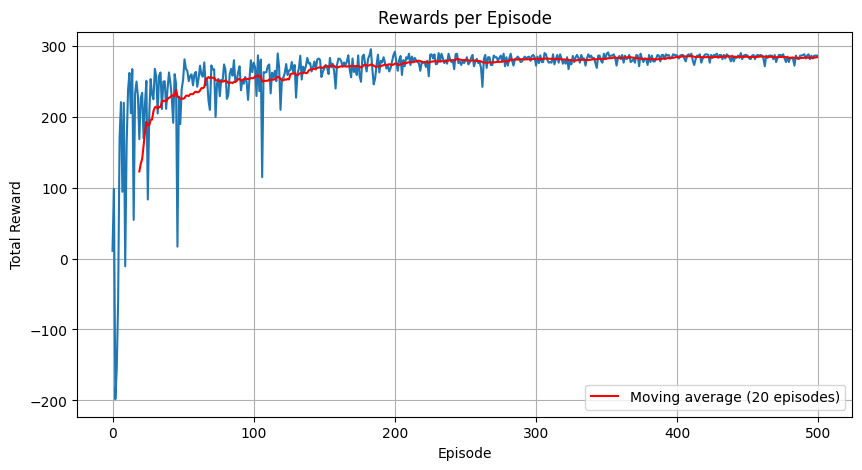


State-Action Value Statistics:
Average Q-value: 10.70
Max Q-value: 206.46
Min Q-value: -2.40
Standard deviation: 33.80

Sample Q-values for key states:

Start state Q-values:
Action N: 0.20
Action S: -0.18
Action E: 0.10
Action W: -0.23

Goal state (4, 6) Q-values:
Action N: 0.18
Action S: -0.13
Action E: 0.24
Action W: -0.11

Goal state (9, 9) Q-values:
Action N: 0.09
Action S: -0.16
Action E: 0.16
Action W: -0.11

Q-value Evolution:

Q-value evolution during training:
--------------------------------------------------
Episode    Avg Q-value     Start State Q-values
--------------------------------------------------
0          1.202          N:0.10 S:-0.15 E:0.27 W:-0.28
50         5.186          N:2.97 S:5.40 E:13.01 W:2.99
100        9.601          N:7.49 S:8.05 E:23.48 W:10.70
150        13.213          N:19.70 S:10.75 E:47.41 W:22.34
200        15.399          N:31.21 S:12.24 E:97.28 W:56.75
250        16.585          N:48.42 S:18.46 E:134.08 W:74.34
300        17.077          N:

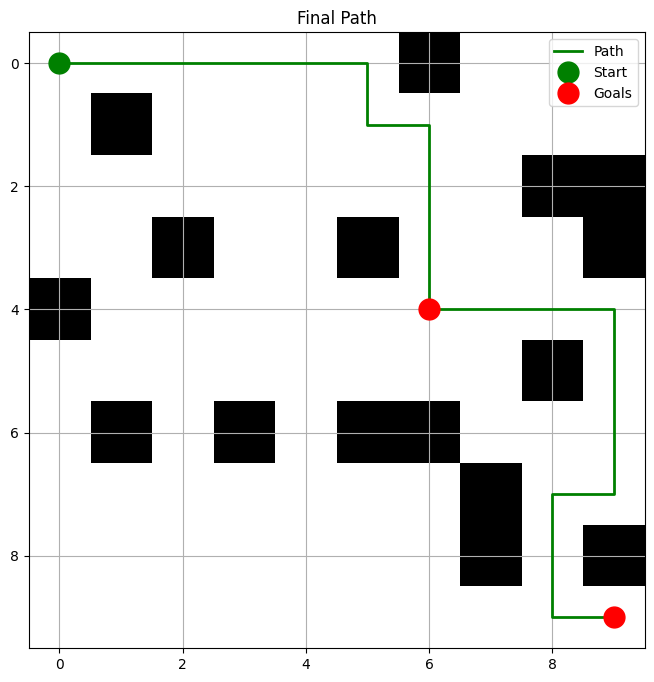

In [7]:
def main():
    # Initialize the environment and robot
    env = Environment(size=10, obstacle_density=0.2, num_goals=2)
    robot_position = (0, 0)
    goals = env.get_goals()

    robot = Robot(position=robot_position, environment=env, goals=goals)

    # Initialize Q-learning agent
    qlearning_agent = QLearning(robot)

    # Train the agent using Q-learning
    qlearning_agent.train(episodes=500)

    # Analyze and visualize results
    qlearning_agent.analyze_performance()

    # Only keep the final path visualization
    path = qlearning_agent.find_path()
    if path:
        print(f"Final path length: {len(path)}")
        print(f"Final path: {path}")
        robot.position = (0, 0)  # reset before visualizing
        comparison = SearchComparison(robot, {'Q-Learning': lambda x: path})
        comparison.visualize_grid(path=path, title="Final Path")
    else:
        print("No path found")

if __name__ == "__main__":
    main()
